In [213]:
# =========================
# Core Libraries
# =========================
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn
# =========================
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# TensorFlow / Keras
# =========================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [214]:
df = pd.read_csv("saved_model/dataset/Language Detection.csv")
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [216]:
df.duplicated().sum()

np.int64(66)

In [217]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [218]:
df.Language.unique()

array(['English', 'Malayalam', 'Hindi', 'Tamil', 'Portugeese', 'French',
       'Dutch', 'Spanish', 'Greek', 'Russian', 'Danish', 'Italian',
       'Turkish', 'Sweedish', 'Arabic', 'German', 'Kannada'], dtype=object)

In [219]:
df.Language.value_counts() 

Language
English       1382
French        1007
Spanish        816
Portugeese     736
Italian        694
Russian        688
Sweedish       673
Malayalam      591
Dutch          542
Arabic         532
Turkish        471
German         465
Tamil          464
Danish         424
Kannada        366
Greek          358
Hindi           62
Name: count, dtype: int64

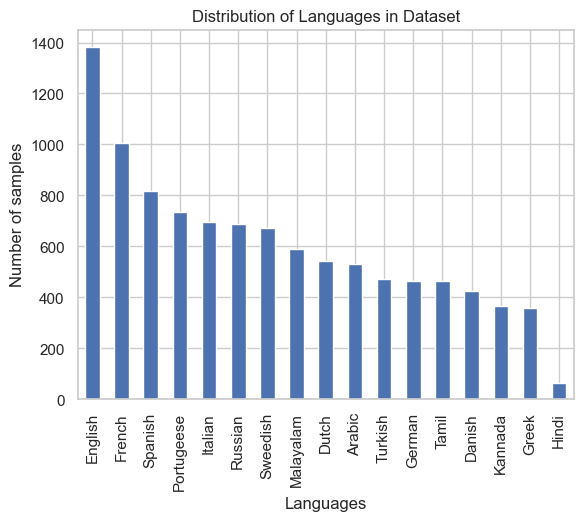

In [220]:
# Class Imbalance Visualization
df.Language.value_counts().plot(kind='bar')
plt.xlabel('Languages')
plt.ylabel('Number of samples')
plt.title('Distribution of Languages in Dataset')
plt.show()

In [221]:
# Encode labels
label_encoder = LabelEncoder()
df["Language_encoded"] = label_encoder.fit_transform(df["Language"])

In [222]:
print(df.Language.unique())
print(df.Language_encoded.unique())

['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']
[ 3 10  7 15 11  4  2 13  6 12  1  8 16 14  0  5  9]


In [223]:
df.drop("Language_encoded", axis=1, inplace=True)
df["Language"] = label_encoder.fit_transform(df["Language"])

In [224]:
# Tokenization
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Text"])

In [225]:
sequences = tokenizer.texts_to_sequences(df["Text"])
sequences[:3]

[[84, 8, 4, 11195, 4933, 22, 4, 702, 2714, 1386, 959, 115, 2715],
 [84, 152, 7998, 14, 4, 11196, 9, 4, 2714, 959, 11, 236, 14, 324, 8, 730],
 [4, 787, 9, 84, 22, 3, 1189, 255, 201, 4, 516, 468, 9, 602]]

In [226]:
X = pad_sequences(sequences, maxlen=60)
X

array([[   0,    0,    0, ...,  959,  115, 2715],
       [   0,    0,    0, ...,  324,    8,  730],
       [   0,    0,    0, ...,  468,    9,  602],
       ...,
       [   0,    0,    0, ...,    1,  650,    1],
       [   0,    0,    0, ...,  136, 8588,    1],
       [   0,    0,    0, ...,    1,  650,    1]],
      shape=(10271, 60), dtype=int32)

In [227]:
X.shape

(10271, 60)

In [228]:
y = df["Language"]

In [229]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [230]:
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [231]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.1758980964648633),
 1: np.float64(1.4256463647405866),
 2: np.float64(1.1135809162374628),
 3: np.float64(0.4425770308123249),
 4: np.float64(0.6063916156173887),
 5: np.float64(1.2751823684618966),
 6: np.float64(1.649467978317607),
 7: np.float64(8.949891067538127),
 8: np.float64(0.8569044639132248),
 9: np.float64(1.6327503974562798),
 10: np.float64(1.0304778627869058),
 11: np.float64(0.8095378855059612),
 12: np.float64(0.849374547710121),
 13: np.float64(0.736728837876614),
 14: np.float64(0.9240805308739174),
 15: np.float64(1.278555866791161),
 16: np.float64(1.3240934730056406)}

In [232]:
# SimpleRNN model
model = Sequential([
    Embedding(input_dim=15000, output_dim=64, input_length=80),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")
])

c:\Users\Admin\AppData\Local\conda\conda\envs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [233]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [234]:
# Reduced learning rate
optimizer = Adam(learning_rate=0.0005)

In [235]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [236]:
# Train model with class weights
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2117 - loss: 2.5596 - val_accuracy: 0.4584 - val_loss: 1.8702
Epoch 2/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6196 - loss: 1.5310 - val_accuracy: 0.8141 - val_loss: 0.9411
Epoch 3/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8903 - loss: 0.6806 - val_accuracy: 0.9255 - val_loss: 0.4727
Epoch 4/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9383 - loss: 0.3751 - val_accuracy: 0.9343 - val_loss: 0.3162
Epoch 5/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9322 - loss: 0.3445 - val_accuracy: 0.9387 - val_loss: 0.3033
Epoch 6/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9671 - loss: 0.1953 - val_accuracy: 0.9440 - val_loss: 0.2287
Epoch 7/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9748 - loss: 0.1377 - val_accuracy: 0.9499 - val_loss: 0.1972
Epoch 8/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9796 - loss: 0.1114 - 

In [247]:
# Save model
model.save("saved_model/simple_rnn_model.h5")

# Save tokenizer & label encoder
with open("saved_model/tokenizer.pkl", "wb") as f:
    pickle.dump((tokenizer, label_encoder), f)

print("Model training completed and saved.")

Model training completed and saved.


### **Model Loading**

In [238]:
#load model
model = load_model("saved_model/simple_rnn_model.h5")

In [239]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

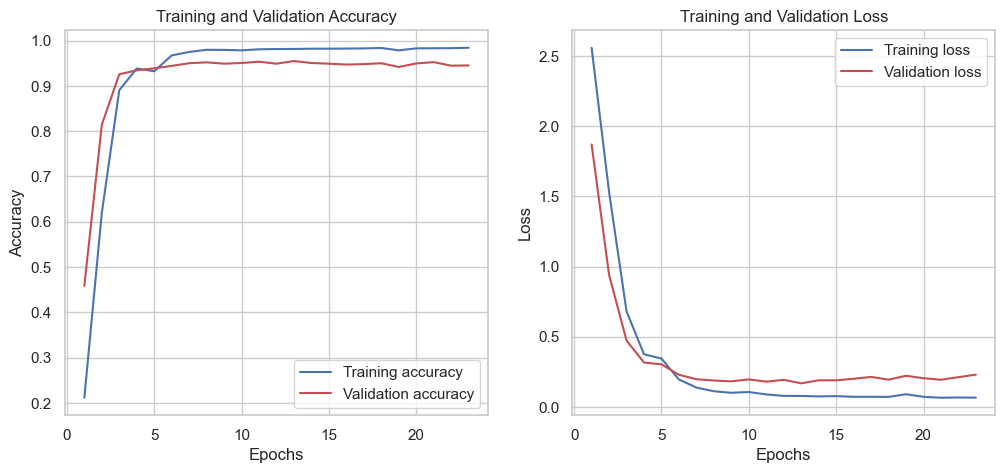

In [240]:
plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [241]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9547 - loss: 0.1679
Test Accuracy: 0.9547
Test Loss: 0.1679


In [242]:
# Predictions on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred_classes[:10]

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([16, 16,  4,  3, 11,  3,  0,  4,  6, 16])

In [243]:
# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      Arabic       0.97      0.97      0.97       121
      Danish       0.92      0.96      0.94        85
       Dutch       0.93      0.93      0.93       108
     English       0.99      0.99      0.99       290
      French       0.98      0.91      0.94       210
      German       1.00      0.98      0.99        86
       Greek       0.98      0.97      0.98        65
       Hindi       0.89      1.00      0.94         8
     Italian       0.98      0.96      0.97       130
     Kannada       0.64      0.99      0.78        70
   Malayalam       1.00      0.95      0.97       122
  Portugeese       0.98      0.94      0.96       139
     Russian       0.99      0.97      0.98       119
     Spanish       0.93      0.96      0.94       160
    Sweedish       0.98      0.95      0.97       150
       Tamil       0.99      0.94      0.96        86
     Turkish       0.92      0.90      0.91       106

    accuracy              

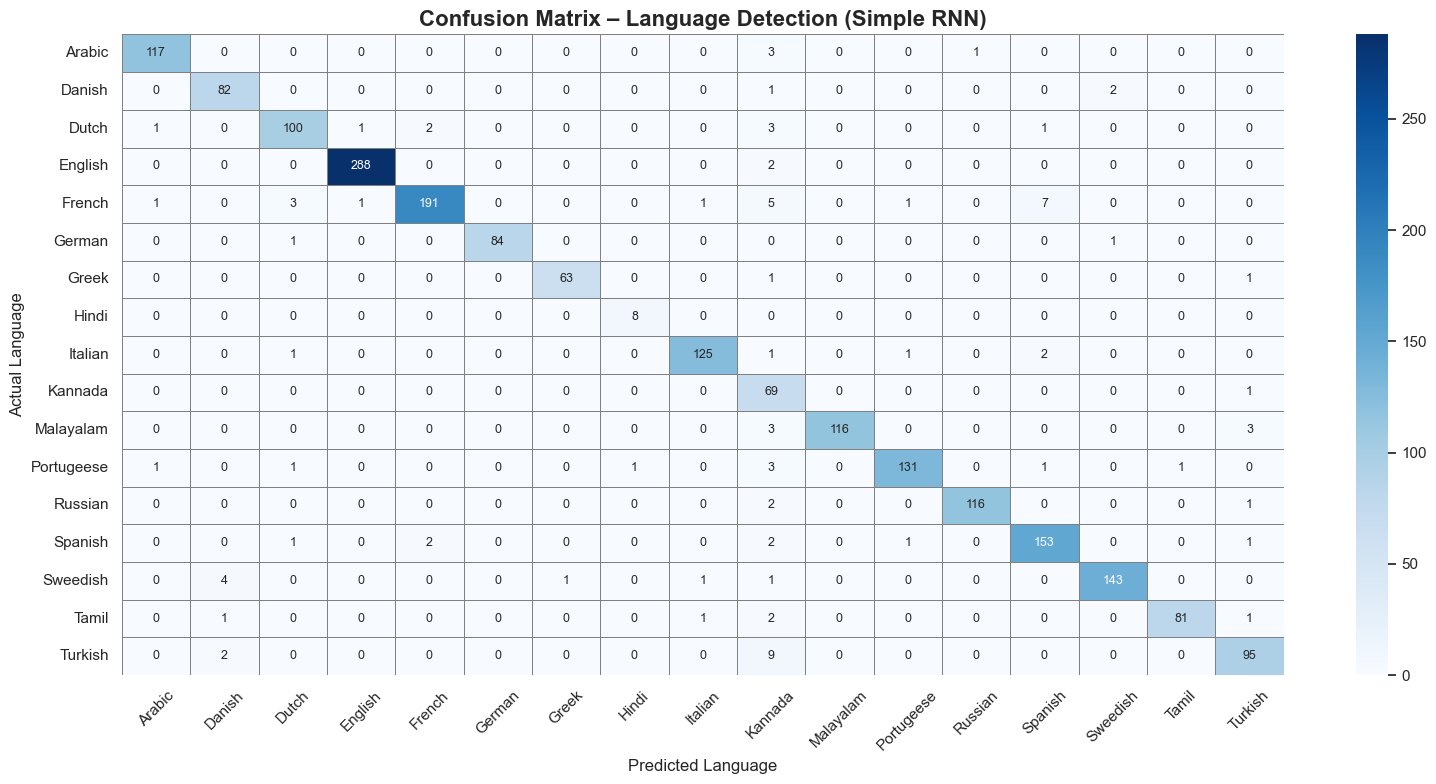

In [244]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="grey",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 9}
)

plt.title("Confusion Matrix – Language Detection (Simple RNN)", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Language", fontsize=12)
plt.ylabel("Actual Language", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()